### Using auto-encoders for anomaly detection and denoising
### The following code is a simple FeedForward neural network-based auto-encoder

In [65]:
import numpy as np
import keras
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
(x_train, y_train),(x_test,y_test) = mnist.load_data()

In [67]:
n, w, h = x_train.shape

In [68]:
n

60000

In [69]:
y_train.shape

(60000,)

In [70]:
m, w, h = x_test.shape

In [71]:
y_test.shape

(10000,)

In [72]:
x_train = x_train.reshape(n,w*h) /255
x_test = x_test.reshape(m, w*h) /255

In [73]:
## Build the auto-encoder
autoencoder = Sequential()
autoencoder.add(Dense(512, activation='elu', input_shape=(w*h,)))
autoencoder.add(Dense(128, activation='elu'))
autoencoder.add(Dense(10, activation='linear', name='bottleneck'))
autoencoder.add(Dense(128, activation='elu'))
autoencoder.add(Dense(512, activation='elu'))
autoencoder.add(Dense(h*w, activation='sigmoid'))

In [74]:
autoencoder.compile(loss='mean_squared_error', optimizer=Adam())

In [75]:
trained_model = autoencoder.fit(x_train, x_train, batch_size=1024, epochs=10)

Epoch 1/10
59/59 [==============================] - 1s 11ms/step - loss: 0.0776
Epoch 2/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0423
Epoch 3/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0340
Epoch 4/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0291
Epoch 5/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0257
Epoch 6/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0236
Epoch 7/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0222
Epoch 8/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0211
Epoch 9/10
59/59 [==============================] - 1s 10ms/step - loss: 0.0203
Epoch 10/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0195


In [76]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

In [77]:
encoded_data = encoder.predict(x_train)

In [78]:
encoded_data.shape

(60000, 10)

In [79]:
decoded_data = autoencoder.predict(x_train)

In [80]:
decoded_data.shape

(60000, 784)

In [81]:
encoded_input = Input(shape=(encoded_data.shape[1],))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [82]:
img = image.load_img('flower.jpg', target_size=(28,28), color_mode='grayscale')
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,h*w)
autoencoded = autoencoder.predict(inputs)

In [83]:
autoencoded.shape

(1, 784)

In [84]:
np.linalg.norm(inputs-autoencoded, axis=-1)
# if the result is alot higher than the loss, it means this image is an anomaly

array([6135.918], dtype=float32)

In [85]:
np.linalg.norm(x_train[0].reshape(1, h*w)- autoencoder.predict(x_train[0].reshape(1, h*w)), axis=-1)

array([5.53755441])

### Autoencoders for denoising

In [126]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [127]:
n, w, h = x_train.shape

In [128]:
noise_factor = 0.5

In [129]:
noises = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

In [130]:
noises.shape

(60000, 28, 28)

In [131]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [132]:
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

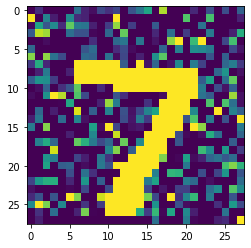

In [133]:
plt.imshow(x_test_noisy[0].reshape(w,h))

In [134]:
import tensorflow as tf

In [135]:
adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)

In [136]:
input_img = Input(shape=(w,h, 1))

nn = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
nn = MaxPooling2D((2,2),padding='same')(nn)
nn = Conv2D(32,(3,3), activation='relu', padding='same')(nn)
encoder = MaxPooling2D((2,2), padding='same')(nn)

nn = Conv2D(32,(3,3), activation='relu', padding='same')(encoder)
nn = UpSampling2D((2,2))(nn)
nn = Conv2D(32, (3,3), activation='relu', padding='same')(nn)
nn = UpSampling2D((2,2))(nn)
decoder = Conv2D(1, (3,3), activation='sigmoid', padding='same')(nn)

autoencoder2 = Model(input_img, decoder)
autoencoder2.compile(optimizer=adadelta, loss='binary_crossentropy')
autoencoder2.fit(x_train_noisy, x_train, batch_size = 256, epochs=50, validation_data=(x_test_noisy, x_test))


Epoch 1/50
235/235 [==============================] - 15s 62ms/step - loss: -0.1059 - val_loss: -1.2491
Epoch 2/50
235/235 [==============================] - 14s 61ms/step - loss: -321.9148 - val_loss: -502.1725
Epoch 3/50
235/235 [==============================] - 14s 61ms/step - loss: -495.0074 - val_loss: -502.3231
Epoch 4/50
235/235 [==============================] - 14s 60ms/step - loss: -495.1535 - val_loss: -502.4672
Epoch 5/50
235/235 [==============================] - 14s 61ms/step - loss: -495.2993 - val_loss: -502.6129
Epoch 6/50
235/235 [==============================] - 14s 61ms/step - loss: -495.4453 - val_loss: -502.7581
Epoch 7/50
235/235 [==============================] - 14s 61ms/step - loss: -495.5912 - val_loss: -502.9059
Epoch 8/50
235/235 [==============================] - 14s 60ms/step - loss: -495.7424 - val_loss: -503.0603
Epoch 9/50
235/235 [==============================] - 14s 59ms/step - loss: -495.9034 - val_loss: -503.2307
Epoch 10/50
235/235 [===========

In [192]:
decoded_img = autoencoder2.predict(x_test_noisy[0].reshape(1, w, h, 1))

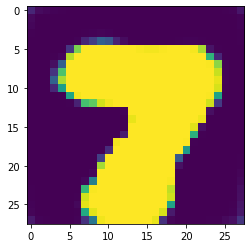

In [196]:
plt.imshow(decoded_img[0,:,:,0])

In [197]:
decoded_img.shape

(1, 28, 28, 1)

In [148]:
x_test_noisy[0].reshape(w, h, 1).shape

(28, 28, 1)

In [158]:
x = Conv2D(32, (3,3), activation='relu', padding='same')(x_test_noisy[0].reshape(1, w, h, 1))
print(x.shape)

x = MaxPooling2D((2,2),padding='same')(x)
print(x.shape)

x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
print(x.shape)

x = MaxPooling2D((2,2), padding='same')(x)
print(x.shape)

x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
print(x.shape)

x = UpSampling2D((2,2))(x)
print(x.shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
print(x.shape)

x = UpSampling2D((2,2))(x)
print(x.shape)

x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
print(x.shape)

(1, 28, 28, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 7, 7, 32)
(1, 7, 7, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 28, 28, 32)
(1, 28, 28, 1)


In [165]:
a = autoencoder2.predict(x_test_noisy[0].reshape(1,w, h, 1))

In [166]:
a.shape

(1, 28, 28, 1)

In [171]:
x_test_noisy[0].reshape(w, h, 1).shape

(28, 28, 1)